In [1]:
import warnings
warnings.filterwarnings('ignore')

# import preprocessing function
from helpers.preprocessing import *

# import dependencies
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from config import db_password
import matplotlib.pyplot as plt

# import machine learning dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import multiprocessing

# import neural network dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

## Read the Data from SQL

In [2]:
X, y = preprocessing('fall')
X.head()

,accommodates,longitude,latitude,availability_90,minimum_nights,host_listings_count,review_scores_rating,bathrooms,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,property_Camper/RV,property_Entire Home,property_Entire Unit,property_Other,property_Private room,property_Shared room
0,8,-117.25760,32.80751,6,4,5.0,4.76,2.0,1,0,0,0,0,1,0,0,0,0
1,1,-117.21931,32.74217,54,1,3.0,4.33,1.0,0,0,1,0,0,0,0,0,1,0
2,7,-117.25416,32.79783,0,6,2.0,4.75,2.5,1,0,0,0,0,1,0,0,0,0
3,8,-117.25728,32.80751,44,6,2.0,4.72,2.0,1,0,0,0,0,1,0,0,0,0
4,3,-117.26856,32.81301,42,5,2.0,4.94,1.0,1,0,0,0,0,1,0,0,0,0


In [3]:
log_y = np.log10(y)
log_y.describe()

count    14026.000000
mean         2.308521
std          0.371718
min          1.000000
25%          2.075547
50%          2.276462
75%          2.515874
max          5.000000
Name: price, dtype: float64

# Split the Data into Training and Testing

In [4]:
X.describe()

,accommodates,longitude,latitude,availability_90,minimum_nights,host_listings_count,review_scores_rating,bathrooms,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,property_Camper/RV,property_Entire Home,property_Entire Unit,property_Other,property_Private room,property_Shared room
count,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000
mean,4.866391,-117.173776,32.763467,48.910737,6.695066,57.060530,4.749504,1.603629,0.838372,0.001069,0.155497,0.005062,0.005989,0.406459,0.422644,0.003066,0.156780,0.005062
std,3.133007,0.074927,0.096004,31.546411,19.525722,215.271203,0.387233,0.984302,0.368123,0.032686,0.362391,0.070970,0.077159,0.491190,0.493997,0.055286,0.363606,0.070970
min,1.000000,-117.282580,32.519860,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,-117.248773,32.719043,19.000000,1.000000,1.000000,4.710000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,-117.166917,32.756855,55.000000,2.000000,4.000000,4.820000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,-117.129102,32.798990,77.000000,4.000000,18.000000,4.950000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,16.000000,-116.896560,33.125690,90.000000,999.000000,2641.000000,5.000000,27.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, log_y, random_state=23)

In [6]:
y_train.describe()

count    10519.000000
mean         2.308008
std          0.369463
min          1.000000
25%          2.075547
50%          2.274158
75%          2.513218
max          5.000000
Name: price, dtype: float64

In [7]:
y_test.describe()

count    3507.000000
mean        2.310059
std         0.378452
min         1.278754
25%         2.068186
50%         2.276462
75%         2.521138
max         4.000000
Name: price, dtype: float64

In [8]:
# scale the X data
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## XGBoost Model

In [9]:
# create a XGBooster regression model and use GridSearch to test various fits
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[11:23:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [10]:
# show results of best model in grid
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7878577694388689
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [11]:
# use xgb_grid model to predict prices for testing and training groups
pred_test = xgb_grid.best_estimator_.predict(X_test)
pred_train = xgb_grid.best_estimator_.predict(X_train)

# mean squared error isn't meaningful with logarithmic data
print("\nTraining MSE:", round(mean_squared_error(10**y_train, 10**pred_train),4))
print("Testing MSE:", round(mean_squared_error(10**y_test, 10**pred_test),4))

# mean absolute error as sqrt of MSE
print("\nTraining MAE:", round(mean_squared_error(10**y_train, 10**pred_train)**0.5,4))
print("Testing MAE:", round(mean_squared_error(10**y_test, 10**pred_test)**0.5,4))

# print r2 values for training and testing models
print("\nTraining r2:", round(r2_score(y_train, pred_train),4))
print("Testing r2:", round(r2_score(y_test, pred_test),4))


Training MSE: 991854.7104
Testing MSE: 103675.0168

Training MAE: 995.919
Testing MAE: 321.9861

Training r2: 0.8926
Testing r2: 0.8156


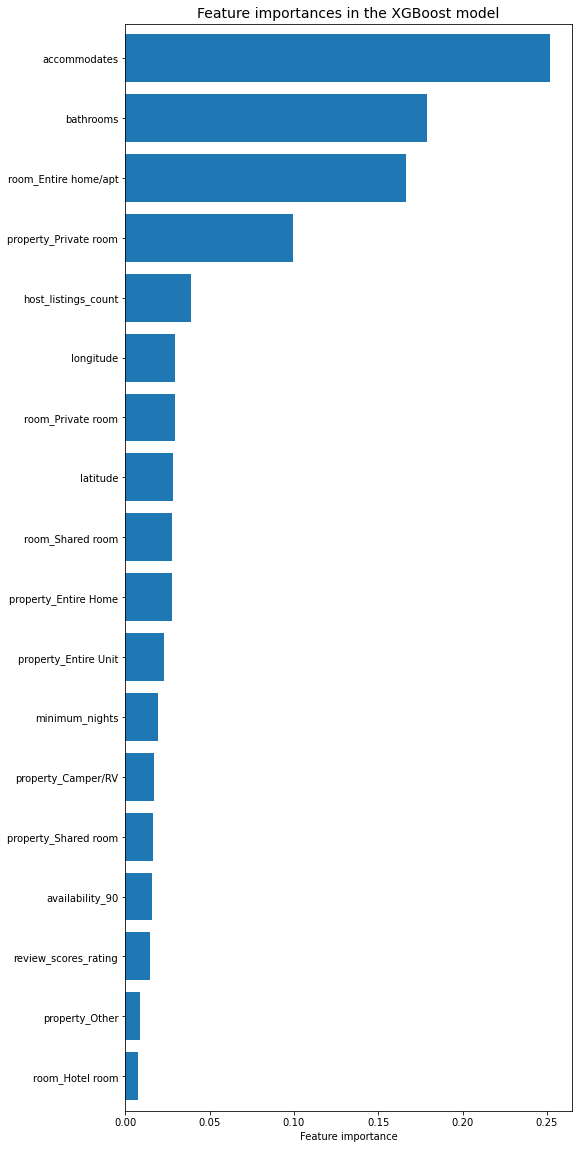

In [12]:
# plot the importance of features in the xgb_grid model
ft_weights_xgb_grid = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_grid.sort_values('weight', inplace=True)

plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_grid.index, ft_weights_xgb_grid.weight, align='center')
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [13]:
# a simpler XGBooster model, without the grid search

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_training_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

In [14]:
# print the r2 scores for the simple xgb_model
print("\nTraining r2:", round(r2_score(y_train, xgb_training_preds),4))
print("Testing r2:", round(r2_score(y_test, xgb_test_preds),4))


Training r2: 0.9187
Testing r2: 0.8069


## Neural Network

In [15]:
X_train_scaled.shape

(10519, 18)

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train_scaled.shape[1]
hidden_nodes_layer1 = 60
hidden_nodes_layer2 = 120
hidden_nodes_layer3 = 120

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1140      
                                                                 
 dense_1 (Dense)             (None, 120)               7320      
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dense_3 (Dense)             (None, 1)                 121       
                                                                 
Total params: 23,101
Trainable params: 23,101
Non-trainable params: 0
_________________________________________________________________


In [17]:
nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics = ['mean_squared_error'])

In [18]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

Epoch 1/50
329/329 [==============================] - 3s 3ms/step - loss: 0.7831 - mean_squared_error: 71.3647
Epoch 2/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2546 - mean_squared_error: 0.1237
Epoch 3/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2517 - mean_squared_error: 0.1197
Epoch 4/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2290 - mean_squared_error: 0.0978
Epoch 5/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2272 - mean_squared_error: 0.0956
Epoch 6/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2268 - mean_squared_error: 0.0956
Epoch 7/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2297 - mean_squared_error: 0.0981
Epoch 8/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2382 - mean_squared_error: 0.1038
Epoch 9/50
329/329 [==============================] - 1s 4ms/step - loss: 0.2513 - mean_squared_error: 0.1124
Epoch 10/

In [19]:
# Evaluate the mean absolute error of the  model using the test data
nn_train_preds = nn.predict(X_train_scaled)
nn_test_preds = nn.predict(X_test_scaled)

print("\nTraining MSE:", round(mean_squared_error(10**y_train, 10**nn_train_preds),4))
print("Testing MSE:", round(mean_squared_error(10**y_test, 10**nn_test_preds),4))

print("\nTraining MAE:", round(mean_squared_error(10**y_train, 10**nn_train_preds)**0.5,4))
print("Testing MAE:", round(mean_squared_error(10**y_test, 10**nn_test_preds)**0.5,4))

print("\nTraining r2:", round(r2_score(y_train, nn_train_preds),4))
print("Testing r2:", round(r2_score(y_test, nn_test_preds),4))

110/110 [==============================] - 0s 3ms/step

Training MSE: 1578678.1428
Testing MSE: 665826.6604

Training MAE: 1256.4546
Testing MAE: 815.982

Training r2: -0.0002
Testing r2: -0.0003
